In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "xgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-15 15:26:27.010858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 15:26:27.499777: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 15:26:28.850797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_138


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [16:40<00:00,  3.61s/it]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,same_count_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,same_count_rolling_square_mean_100_shift_1000,reduce_step,fold
55,-88.1250,0.067688,0.067688,-13.195312,0.028885,0.000187,0.031830,627.5,0.0,47427.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,665,3
56,-88.1250,0.062500,0.062500,-13.039062,0.028732,0.000293,0.025177,687.5,0.0,47487.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,677,3
57,-88.8750,0.140625,0.140625,-2.054688,0.029480,0.000575,0.077698,747.5,0.0,47547.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,689,3
58,-89.3125,0.000000,0.000000,-14.140625,0.029739,0.000210,0.109192,807.5,0.0,47607.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,701,3
59,-89.2500,0.104187,0.104187,-6.000000,0.029984,0.000322,0.098938,867.5,0.0,47667.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,713,3


(948910, 1627)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["xgboost"], 
        es_rounds=200,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.55478
[100]	eval-rmse:1.14126
[200]	eval-rmse:1.02968
[300]	eval-rmse:0.99797
[400]	eval-rmse:0.98685
[500]	eval-rmse:0.98210
[600]	eval-rmse:0.97975
[700]	eval-rmse:0.97823
[800]	eval-rmse:0.97715
[900]	eval-rmse:0.97635
[1000]	eval-rmse:0.97578
[1100]	eval-rmse:0.97523
[1200]	eval-rmse:0.97458
[1300]	eval-rmse:0.97418
[1400]	eval-rmse:0.97391
[1500]	eval-rmse:0.97358
[1600]	eval-rmse:0.97332
[1700]	eval-rmse:0.97310
[1800]	eval-rmse:0.97285
[1900]	eval-rmse:0.97250
[2000]	eval-rmse:0.97243
[2100]	eval-rmse:0.97245
[2200]	eval-rmse:0.97238
[2300]	eval-rmse:0.97233
[2400]	eval-rmse:0.97227
[2500]	eval-rmse:0.97217
[2600]	eval-rmse:0.97214
[2700]	eval-rmse:0.97209
[2800]	eval-rmse:0.97214
[2884]	eval-rmse:0.97228


 20%|██        | 1/5 [05:59<23:58, 359.71s/it]

== fold 1 ==
[0]	eval-rmse:1.54504
[100]	eval-rmse:1.15502
[200]	eval-rmse:1.05292
[300]	eval-rmse:1.02317
[400]	eval-rmse:1.01179
[500]	eval-rmse:1.00618
[600]	eval-rmse:1.00327
[700]	eval-rmse:1.00141
[800]	eval-rmse:1.00009
[900]	eval-rmse:0.99898
[1000]	eval-rmse:0.99792
[1100]	eval-rmse:0.99698
[1200]	eval-rmse:0.99613
[1300]	eval-rmse:0.99556
[1400]	eval-rmse:0.99489
[1500]	eval-rmse:0.99449
[1600]	eval-rmse:0.99410
[1700]	eval-rmse:0.99374
[1800]	eval-rmse:0.99341
[1900]	eval-rmse:0.99310
[2000]	eval-rmse:0.99284
[2100]	eval-rmse:0.99271
[2200]	eval-rmse:0.99247
[2300]	eval-rmse:0.99236
[2400]	eval-rmse:0.99224
[2500]	eval-rmse:0.99211
[2600]	eval-rmse:0.99197
[2700]	eval-rmse:0.99182
[2800]	eval-rmse:0.99160
[2900]	eval-rmse:0.99146
[3000]	eval-rmse:0.99126
[3100]	eval-rmse:0.99120
[3200]	eval-rmse:0.99110
[3300]	eval-rmse:0.99111
[3400]	eval-rmse:0.99114
[3500]	eval-rmse:0.99101
[3600]	eval-rmse:0.99093
[3700]	eval-rmse:0.99090
[3800]	eval-rmse:0.99084
[3900]	eval-rmse:0.99079

 40%|████      | 2/5 [14:59<23:17, 465.70s/it]

== fold 2 ==
[0]	eval-rmse:1.60409
[100]	eval-rmse:1.21703
[200]	eval-rmse:1.11179
[300]	eval-rmse:1.08038
[400]	eval-rmse:1.06830
[500]	eval-rmse:1.06311
[600]	eval-rmse:1.06069
[700]	eval-rmse:1.05919
[800]	eval-rmse:1.05806
[900]	eval-rmse:1.05719
[1000]	eval-rmse:1.05627
[1100]	eval-rmse:1.05555
[1200]	eval-rmse:1.05497
[1300]	eval-rmse:1.05460
[1400]	eval-rmse:1.05417
[1500]	eval-rmse:1.05382
[1600]	eval-rmse:1.05346
[1700]	eval-rmse:1.05316
[1800]	eval-rmse:1.05290
[1900]	eval-rmse:1.05264
[2000]	eval-rmse:1.05249
[2100]	eval-rmse:1.05239
[2200]	eval-rmse:1.05236
[2300]	eval-rmse:1.05222
[2400]	eval-rmse:1.05218
[2500]	eval-rmse:1.05221
[2600]	eval-rmse:1.05213
[2700]	eval-rmse:1.05209
[2800]	eval-rmse:1.05205
[2900]	eval-rmse:1.05192
[3000]	eval-rmse:1.05198
[3100]	eval-rmse:1.05194
[3124]	eval-rmse:1.05195


 60%|██████    | 3/5 [21:27<14:20, 430.21s/it]

== fold 3 ==
[0]	eval-rmse:1.57927
[100]	eval-rmse:1.17323
[200]	eval-rmse:1.07063
[300]	eval-rmse:1.04286
[400]	eval-rmse:1.03287
[500]	eval-rmse:1.02680
[600]	eval-rmse:1.02342
[700]	eval-rmse:1.02134
[800]	eval-rmse:1.01972
[900]	eval-rmse:1.01881
[1000]	eval-rmse:1.01807
[1100]	eval-rmse:1.01718
[1200]	eval-rmse:1.01668
[1300]	eval-rmse:1.01592
[1400]	eval-rmse:1.01546
[1500]	eval-rmse:1.01505
[1600]	eval-rmse:1.01466
[1700]	eval-rmse:1.01416
[1800]	eval-rmse:1.01404
[1900]	eval-rmse:1.01380
[2000]	eval-rmse:1.01361
[2100]	eval-rmse:1.01339
[2200]	eval-rmse:1.01326
[2300]	eval-rmse:1.01308
[2400]	eval-rmse:1.01296
[2500]	eval-rmse:1.01291
[2600]	eval-rmse:1.01308
[2700]	eval-rmse:1.01316
[2702]	eval-rmse:1.01317


 80%|████████  | 4/5 [27:08<06:34, 394.93s/it]

== fold 4 ==
[0]	eval-rmse:1.59930
[100]	eval-rmse:1.19580
[200]	eval-rmse:1.08921
[300]	eval-rmse:1.05987
[400]	eval-rmse:1.04942
[500]	eval-rmse:1.04458
[600]	eval-rmse:1.04223
[700]	eval-rmse:1.04061
[800]	eval-rmse:1.03947
[900]	eval-rmse:1.03878
[1000]	eval-rmse:1.03822
[1100]	eval-rmse:1.03760
[1200]	eval-rmse:1.03721
[1300]	eval-rmse:1.03696
[1400]	eval-rmse:1.03677
[1500]	eval-rmse:1.03645
[1600]	eval-rmse:1.03618
[1700]	eval-rmse:1.03606
[1800]	eval-rmse:1.03594
[1900]	eval-rmse:1.03577
[2000]	eval-rmse:1.03569
[2100]	eval-rmse:1.03554
[2200]	eval-rmse:1.03545
[2300]	eval-rmse:1.03544
[2400]	eval-rmse:1.03529
[2500]	eval-rmse:1.03513
[2600]	eval-rmse:1.03514
[2700]	eval-rmse:1.03509
[2800]	eval-rmse:1.03513
[2880]	eval-rmse:1.03518


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.55498
[100]	eval-rmse:1.12643
[200]	eval-rmse:1.01349
[300]	eval-rmse:0.98194
[400]	eval-rmse:0.97157
[500]	eval-rmse:0.96755
[600]	eval-rmse:0.96522
[700]	eval-rmse:0.96384
[800]	eval-rmse:0.96292
[900]	eval-rmse:0.96242
[1000]	eval-rmse:0.96201
[1100]	eval-rmse:0.96154
[1200]	eval-rmse:0.96126
[1300]	eval-rmse:0.96076
[1400]	eval-rmse:0.96042
[1500]	eval-rmse:0.96015
[1600]	eval-rmse:0.95982
[1700]	eval-rmse:0.95970
[1800]	eval-rmse:0.95954
[1900]	eval-rmse:0.95939
[2000]	eval-rmse:0.95916
[2100]	eval-rmse:0.95898
[2200]	eval-rmse:0.95876
[2300]	eval-rmse:0.95869
[2400]	eval-rmse:0.95865
[2500]	eval-rmse:0.95860
[2600]	eval-rmse:0.95847
[2700]	eval-rmse:0.95827
[2800]	eval-rmse:0.95815
[2900]	eval-rmse:0.95808
[3000]	eval-rmse:0.95812
[3100]	eval-rmse:0.95808
[3200]	eval-rmse:0.95795
[3300]	eval-rmse:0.95795
[3400]	eval-rmse:0.95801
[3483]	eval-rmse:0.95802


 20%|██        | 1/5 [07:07<28:28, 427.24s/it]

== fold 1 ==
[0]	eval-rmse:1.54487
[100]	eval-rmse:1.12538
[200]	eval-rmse:1.01179
[300]	eval-rmse:0.97723
[400]	eval-rmse:0.96238
[500]	eval-rmse:0.95509
[600]	eval-rmse:0.95189
[700]	eval-rmse:0.94988
[800]	eval-rmse:0.94850
[900]	eval-rmse:0.94743
[1000]	eval-rmse:0.94662
[1100]	eval-rmse:0.94596
[1200]	eval-rmse:0.94522
[1300]	eval-rmse:0.94476
[1400]	eval-rmse:0.94436
[1500]	eval-rmse:0.94401
[1600]	eval-rmse:0.94374
[1700]	eval-rmse:0.94362
[1800]	eval-rmse:0.94355
[1900]	eval-rmse:0.94348
[2000]	eval-rmse:0.94338
[2100]	eval-rmse:0.94320
[2200]	eval-rmse:0.94308
[2300]	eval-rmse:0.94321
[2394]	eval-rmse:0.94323


 40%|████      | 2/5 [12:09<17:41, 353.93s/it]

== fold 2 ==
[0]	eval-rmse:1.60544
[100]	eval-rmse:1.20789
[200]	eval-rmse:1.09961
[300]	eval-rmse:1.06687
[400]	eval-rmse:1.05443
[500]	eval-rmse:1.04981
[600]	eval-rmse:1.04734
[700]	eval-rmse:1.04563
[800]	eval-rmse:1.04442
[900]	eval-rmse:1.04348
[1000]	eval-rmse:1.04275
[1100]	eval-rmse:1.04224
[1200]	eval-rmse:1.04196
[1300]	eval-rmse:1.04160
[1400]	eval-rmse:1.04123
[1500]	eval-rmse:1.04092
[1600]	eval-rmse:1.04053
[1700]	eval-rmse:1.04045
[1800]	eval-rmse:1.04030
[1900]	eval-rmse:1.04003
[2000]	eval-rmse:1.03975
[2100]	eval-rmse:1.03945
[2200]	eval-rmse:1.03946
[2300]	eval-rmse:1.03948
[2400]	eval-rmse:1.03945
[2500]	eval-rmse:1.03937
[2600]	eval-rmse:1.03934
[2700]	eval-rmse:1.03931
[2800]	eval-rmse:1.03931
[2900]	eval-rmse:1.03931
[3000]	eval-rmse:1.03932
[3018]	eval-rmse:1.03928


 60%|██████    | 3/5 [18:15<11:58, 359.15s/it]

== fold 3 ==
[0]	eval-rmse:1.57211
[100]	eval-rmse:1.16982
[200]	eval-rmse:1.07564
[300]	eval-rmse:1.05450
[400]	eval-rmse:1.04797
[500]	eval-rmse:1.04524
[600]	eval-rmse:1.04371
[700]	eval-rmse:1.04314
[800]	eval-rmse:1.04272
[900]	eval-rmse:1.04230
[1000]	eval-rmse:1.04166
[1100]	eval-rmse:1.04122
[1200]	eval-rmse:1.04075
[1300]	eval-rmse:1.04060
[1400]	eval-rmse:1.04035
[1500]	eval-rmse:1.04035
[1600]	eval-rmse:1.04003
[1700]	eval-rmse:1.04010
[1800]	eval-rmse:1.04001
[1900]	eval-rmse:1.03994
[2000]	eval-rmse:1.03990
[2100]	eval-rmse:1.03988
[2200]	eval-rmse:1.03989
[2238]	eval-rmse:1.03991


 80%|████████  | 4/5 [22:56<05:28, 328.59s/it]

== fold 4 ==
[0]	eval-rmse:1.59451
[100]	eval-rmse:1.19711
[200]	eval-rmse:1.10153
[300]	eval-rmse:1.07499
[400]	eval-rmse:1.06566
[500]	eval-rmse:1.06127
[600]	eval-rmse:1.05855
[700]	eval-rmse:1.05672
[800]	eval-rmse:1.05537
[900]	eval-rmse:1.05441
[1000]	eval-rmse:1.05347
[1100]	eval-rmse:1.05265
[1200]	eval-rmse:1.05183
[1300]	eval-rmse:1.05135
[1400]	eval-rmse:1.05073
[1500]	eval-rmse:1.05038
[1600]	eval-rmse:1.05004
[1700]	eval-rmse:1.04965
[1800]	eval-rmse:1.04928
[1900]	eval-rmse:1.04911
[2000]	eval-rmse:1.04876
[2100]	eval-rmse:1.04852
[2200]	eval-rmse:1.04821
[2300]	eval-rmse:1.04789
[2400]	eval-rmse:1.04771
[2500]	eval-rmse:1.04766
[2600]	eval-rmse:1.04742
[2700]	eval-rmse:1.04727
[2800]	eval-rmse:1.04715
[2900]	eval-rmse:1.04706
[3000]	eval-rmse:1.04696
[3100]	eval-rmse:1.04688
[3200]	eval-rmse:1.04674
[3300]	eval-rmse:1.04666
[3400]	eval-rmse:1.04658
[3500]	eval-rmse:1.04645
[3600]	eval-rmse:1.04650
[3700]	eval-rmse:1.04647
[3710]	eval-rmse:1.04647


100%|██████████| 5/5 [30:30<00:00, 366.10s/it]


## Dynamic-Range NMS

<AxesSubplot: >

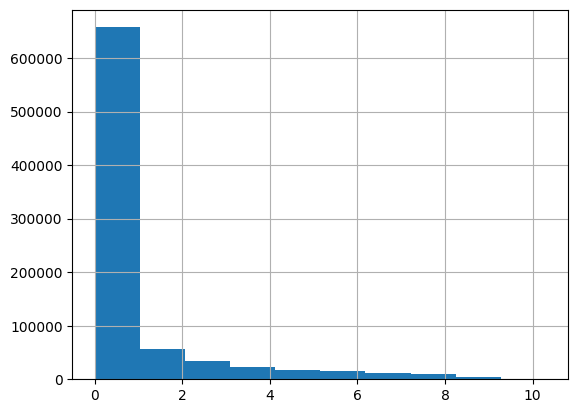

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 47.67it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7941


event   tolerance
onset   12           0.293327
        36           0.702631
        60           0.796856
        90           0.831186
        120          0.854468
        150          0.863147
        180          0.871545
        240          0.885523
        300          0.890769
        360          0.896088
wakeup  12           0.326732
        36           0.712135
        60           0.800275
        90           0.841101
        120          0.857928
        150          0.869186
        180          0.879794
        240          0.893204
        300          0.904382
        360          0.912380
dtype: float64